Using device: cpu
Original: George_W_Bush
Adversarial: Ariel_Sharon
Confidence clean: 0.0493, adversarial: 0.0532


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

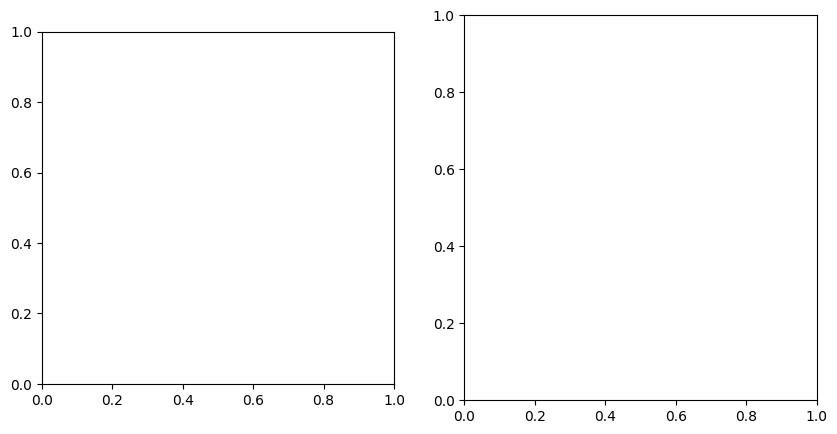

In [2]:
# 3.1 Imports
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 3.2 Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3.3 Load data and model
lfw_path = "../Datasets/lfw-dataset"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
lfw_dataset = datasets.ImageFolder(root=lfw_path, transform=transform)
lfw_loader = DataLoader(lfw_dataset, batch_size=1, shuffle=True)
class_names = lfw_dataset.classes

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("../Models/resnet18_lfw.pth", map_location=device))
model = model.to(device)
model.eval()

# 3.4 FGSM function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed = image + epsilon * sign_data_grad
    return torch.clamp(perturbed, 0, 1)

# 3.5 Find a correctly predicted image
criterion = nn.CrossEntropyLoss()
epsilon = 0.05

for image, label in lfw_loader:
    image, label = image.to(device), label.to(device)
    image.requires_grad = True

    output = model(image)
    init_pred = output.max(1, keepdim=True)[1]

    if init_pred.item() != label.item():
        continue  # Skip misclassified

    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed = fgsm_attack(image, epsilon, data_grad)

    # New prediction
    adv_output = model(perturbed)
    adv_pred = adv_output.max(1, keepdim=True)[1]

    clean_conf = torch.softmax(output, dim=1).max().item()
    adv_conf = torch.softmax(adv_output, dim=1).max().item()

    print(f"Original: {class_names[init_pred.item()]}")
    print(f"Adversarial: {class_names[adv_pred.item()]}")
    print(f"Confidence clean: {clean_conf:.4f}, adversarial: {adv_conf:.4f}")

    # Show images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
    axs[0].set_title(f"Original: {class_names[init_pred.item()]}")
    axs[0].axis("off")
    axs[1].imshow(perturbed.squeeze().permute(1, 2, 0).detach().cpu())
    axs[1].set_title(f"Adversarial: {class_names[adv_pred.item()]}")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()
    break  # Just one example
